In [1]:
# Imports
import ann
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import f1_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from tensorflow import keras

import cv2

import math
import numpy as np
import pandas as pd
from scipy import interpolate
import statistics as stt

from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

from datetime import datetime
import pickle
import re

import customization
import data_fetching
import hyperparameter_optimization as HPO
import utilities
import data_paths

In [2]:
# Spatio-temporal information
sampling_point = None # Water sampling point
time_range = [2012, 2023] # Data time range

# PATHS
inea_path = data_paths.WQ_PATH # Water quality data path
pluvio_path = data_paths.PV_PATH # Pluviometric data path


# HYPERPARAMETERS
iter_length = 5 # Number of model train-test iterations
scaling = True # Data scaling
tts_test_size = 0.1 # Train-Test-Split percentual for the testing data

pluvio_interval = '24h' # How many hours of precipitation before sampling to consider: 01h, 04h, 24h or 96h

ann_epochs = [30, 90] # How many epochs to train the ann-based models [Basic, Deep]
ann_batch_size = 2 # How many data points per batch to use during training
ann_validation_split = 0.15 # Percentual of training data to use for validation

rfr_estimators = 64 # Number of estimatores for Random Forest based models

pluvio_merge_mode = 'patternized' # How to select date and time for pluviometric data before merging
pluvio_hour = '05:00:00' # What hour to use as reference for merging the datasets
pluvio_days_past = 0 # How many days before the water quality sampling to use the pluviometric data from

outlier_stripping = ['pH', 'Coliformes Termotolerantes (NMP/100mL)',
                    'Temperatura da Água (°C)'] # Variables to check and remove outliers from


# Label - Variable to predict
model_var = 'DBO (mg/L)'
# Features - Variables to use as predictors
features = ['pH', 'Coliformes Termotolerantes (NMP/100mL)',
            'Temperatura da Água (°C)', 'Fósforo Total (mg/L)', f'Prec. max em {pluvio_interval} (mm)',
            'OD (mg/L)']
# Variables to fecth from the Water Quality dataset
fetch_vars = [model_var, 'pH', 'pH  ', 'Coliformes Termotolerantes (NMP/100mL)',
             'Coliformes Termotolerantes  (NMP/100mL)', 'Coliformes Termotolerantes (NMP/100 mL)',
             'Temperatura da Água (°C)', 'Fósforo Total (mg/L)',
             'OD (mg/L)', 'OD (mg/L )', 'OD  (mg/L)']

In [3]:
save_data = False # Either to save or not the fetched data
no_outliers = True # Either to remove outliers or not

# Fetches the data from the Water Quality dataset and inserts it into a dataframe.
df = data_fetching.fetch_data(inea_path, ['Data', 'Hora'] + fetch_vars,
                            i_year=time_range[0], f_year=time_range[1])

# Merges duplicate columns from the water quality dataset
df = data_fetching.join_duplicates(df, 'OD (mg/L)', ['OD (mg/L)', 'OD (mg/L )', 'OD  (mg/L)'])
df = data_fetching.join_duplicates(df, 'pH', ['pH', 'pH  '])
df = data_fetching.join_duplicates(df, 'Coliformes Termotolerantes (NMP/100mL)', ['Coliformes Termotolerantes (NMP/100mL)',
                                                                                'Coliformes Termotolerantes  (NMP/100mL)',
                                                                                'Coliformes Termotolerantes (NMP/100 mL)'])

# Merges the pluviometric dataset with the water quality dataset.
df = data_fetching.merge_pluvio(df, pluvio_interval, pluvio_path, mode=pluvio_merge_mode,
                                pattern_hour=pluvio_hour, days_past=pluvio_days_past)

# Drops NaN values
df.dropna(inplace=True)
# Drops duplicated samples
df.drop_duplicates(subset=['Data', 'Local'], keep="last", inplace=True)

# Removes outliers from the dataset on the variables inside the "outlier_stripping" list
outlier_stripping = ['Fósforo Total (mg/L)', 'OD (mg/L)', 'DBO (mg/L)']
if no_outliers:
    for var in (features + [model_var]):
        if var in outlier_stripping:
            df = data_fetching.remove_outliers(df, var)

# Saves the DataFrame into a .csv file
if save_data:
    df.to_csv(data_paths.DF_PATH + rf'\{sampling_point}_{time_range[0]}_{time_range[1]}.csv',
            sep=';', decimal=',', float_format='%.4f')

print(f'Number of rows after preprocessing: {len(df)}')

# Sorts the values by Date
df.sort_values(by='Data', inplace=True)

# Separates the features and labels in two lists: x and y, respectively
x = df[features].values
y = df[model_var].astype('float32').values

Number of rows after preprocessing: 377


In [6]:
df.describe()

,Dia,Mês,Ano,Sem,DiaSem,DBO (mg/L),Temperatura da Água (°C),Fósforo Total (mg/L),OD (mg/L),pH,Coliformes Termotolerantes (NMP/100mL),Prec. max em 24h (mm),pH_T,OD_T,DBO_T,FOSF_T
count,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.00000,377.000000,377.000000,3.770000e+02,377.000000,3.770000e+02,3.770000e+02,3.770000e+02,3.770000e+02
mean,15.352785,6.604774,2016.323608,27.108753,2.538461,14.352255,24.446154,0.97756,4.912228,7.833687,1.702333e+05,3.859416,-1.696256e-16,-2.355911e-17,2.167438e-16,1.554901e-16
std,9.992560,3.414655,2.755324,15.007316,0.898717,8.898425,4.451469,0.51968,3.492099,1.066590,3.664161e+05,12.222898,1.001329e+00,1.001329e+00,1.001329e+00,1.001329e+00
min,1.000000,1.000000,2013.000000,1.000000,1.000000,2.000000,0.000000,0.03000,0.000000,0.000000,0.000000e+00,0.000000,-7.354373e+00,-1.408539e+00,-1.389984e+00,-1.825777e+00
25%,6.000000,4.000000,2014.000000,14.000000,2.000000,8.000000,22.800000,0.60000,2.220000,7.600000,2.300000e+03,0.000000,-2.193887e-01,-7.719729e-01,-7.148115e-01,-7.274894e-01
50%,15.000000,7.000000,2016.000000,27.000000,2.000000,13.000000,24.000000,0.90000,4.400000,7.880000,2.300000e+04,0.000000,4.347938e-02,-1.468769e-01,-1.521676e-01,-1.494435e-01
75%,27.000000,10.000000,2018.000000,40.000000,3.000000,20.000000,27.000000,1.36000,7.000000,8.200000,1.300000e+05,0.200000,3.438995e-01,5.986504e-01,6.355339e-01,7.368935e-01
max,31.000000,12.000000,2022.000000,51.000000,4.000000,44.000000,36.000000,2.54000,19.200001,10.500000,1.600000e+06,60.800000,2.503171e+00,4.096894e+00,3.336225e+00,3.010541e+00


In [5]:
scaler = StandardScaler()
df[['pH_T', 'OD_T', 'DBO_T', 'FOSF_T']] = scaler.fit_transform(df[['pH', 'OD (mg/L)', 'DBO (mg/L)', 'Fósforo Total (mg/L)']])

In [7]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(6,4))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()

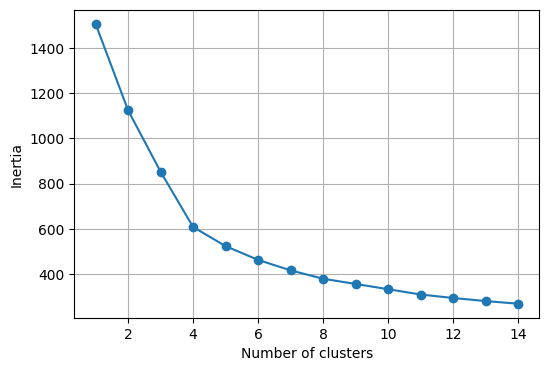

In [29]:
k_means_data = df[['pH_T', 'OD_T', 'DBO_T', 'FOSF_T']]
optimize_k_means(k_means_data, 15)

In [41]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(k_means_data)
df['kmeans_4v4c'] = kmeans.labels_

In [ ]:
fig = px.scatter_3d(df, x='OD (mg/L)', y='Fósforo Total (mg/L)', z='DBO (mg/L)', color='kmeans_3v3c')
fig.show()

In [42]:
k_means_df = df.copy().sort_values(by='kmeans_4v4c')

In [ ]:
k_means_df.head(500)

In [26]:
def describe_kmeans(df, kmeans_column, column='Local'):
    new_df = df.copy()[[column, kmeans_column]]
    sampling_points = new_df[column].unique()
    groups = new_df[kmeans_column].unique()
    result_dict = {}
    for point in sampling_points:
        series_slice = new_df[new_df[column] == point]
        series_dict = {}

        series_entries = len(series_slice)
        for group in groups:
            group_slice = series_slice[series_slice[kmeans_column] == group]
            group_entries = len(group_slice)
            series_group_percentual = group_entries / series_entries
            series_dict[f'% in Cluster {str(group)}'] = round(series_group_percentual * 100, 2)

        result_dict[point] = series_dict
    
    return pd.DataFrame(result_dict)


In [43]:
kmeans_df = describe_kmeans(k_means_df, 'kmeans_4v4c')

In [44]:
kmeans_df

,01RJ20JC0342,01RJ20TJ0303,01RJ20MR0361,01RJ20CM0320,01RJ20MR0369,01RJ20JC0341,01RJ20TJ0306,01RJ20MR0363
% in Cluster 0,1.56,1.54,1.56,1.67,1.69,0.0,0.0,0.00
% in Cluster 1,42.19,4.62,40.62,66.67,6.78,40.0,37.5,0.00
% in Cluster 2,21.88,92.31,28.12,11.67,84.75,0.0,37.5,71.43
% in Cluster 3,34.38,1.54,29.69,20.00,6.78,60.0,25.0,28.57
